In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tqdm import tqdm
from pathlib import Path
import tsfel
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, log_loss, confusion_matrix, classification_report)
from sklearn.base import clone
import numpy as np
from tabulate import tabulate
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight


## Utilidades

In [2]:
def check_robustness(metric_name, metric_values, threshold_percent=10):
    """
    Check the robustness of a model based on k-fold metric values.
    
    A model is considered robust if the coefficient of variation (CV),
    defined as (standard deviation / mean) * 100, is less than threshold_percent.
    
    Parameters:
        metric_values (list or np.array): List/array of metric values from each fold.
        threshold_percent (float): The maximum allowed CV percentage (default: 10).
        
    Returns:
        bool: True if the model is robust (CV < threshold_percent), False otherwise.
    """
    metric_values = np.array(metric_values)
    mean_val = np.mean(metric_values)
    std_val = np.std(metric_values)
    
    # Avoid division by zero:
    if mean_val == 0:
        cv = float('inf')
    else:
        cv = (std_val / mean_val) * 100

    print(f"[{metric_name}] Metric Mean: {mean_val:.4f}")
    print(f"[{metric_name}] Metric Standard Deviation: {std_val:.4f}")
    print(f"[{metric_name}] Coefficient of Variation (CV): {cv:.2f}%")
    
    if cv < threshold_percent:
        print(f"[{metric_name}] Model is robust (CV < {threshold_percent}%)")
        return True
    else:
        print(f"[{metric_name}] Model is not robust (CV >= {threshold_percent}%)")
        return False
    
def get_movement_data(subject_id, base_path, sampling_rate):
    # File path handling
    path = Path(base_path) / f'{subject_id}_ml.bin'
    if not path.exists():
        raise FileNotFoundError(f"Movement data not found for subject {subject_id}")
    
    # Load raw data
    raw_data = np.fromfile(path, dtype=np.float32)
    
    # Channel configuration
    tasks = ["Relaxed1", "Relaxed2", "RelaxedTask1", "RelaxedTask2", 
             "StretchHold", "HoldWeight", "DrinkGlas", "CrossArms", 
             "TouchNose", "Entrainment1", "Entrainment2"]
    wrists = ["Left", "Right"]
    sensors = ["Accelerometer", "Gyroscope"]
    axes = ["X", "Y", "Z"]
    
    # Calculate expected parameters
    n_channels = len(tasks) * len(wrists) * len(sensors) * len(axes)

    # Even though the duration was 10.24 per assessment, the first ~0.5 seconds are not used and thus
    # the preprocessed data has only 9.76 seconds of data
    expected_duration = 9.76  # seconds per assessment
    expected_timepoints = int(expected_duration * sampling_rate)  # 976
    
    # Validate data size
    expected_size = n_channels * expected_timepoints
    #print(f"Expected size: {expected_size} elements")
    if len(raw_data) != expected_size:
        raise ValueError(f"Unexpected data size for {subject_id}: "
                         f"Got {len(raw_data)} elements, expected {expected_size}")
    
    return {
        'tasks': tasks,
        'wrists': wrists,
        'sensors': sensors,
        'axes': axes,
        'raw_data': raw_data,
        'timepoints': expected_timepoints,
    }
    
def load_movement_features(subject_id, base_path='../../data/preprocessed/movement/', sampling_rate=100):
    """
    Load and structure movement data from binary files with proper validation
    
    Args:
        subject_id (str): Subject identifier (e.g., '001')
        base_path (str): Base directory for movement data
        sampling_rate (int): Sampling rate in Hz (used for validation)
    
    Returns:
        dict: Structured data with keys as channel names and values as time series arrays
    """
    movement_data = get_movement_data(subject_id, base_path, sampling_rate)
    tasks = movement_data['tasks']
    wrists = movement_data['wrists']
    sensors = movement_data['sensors']
    axes = movement_data['axes']
    raw_data = movement_data['raw_data']
    timepoints = movement_data['timepoints']
    
    # Reshape and structure the data
    structured_data = {}
    channel_idx = 0
    
    for task in tasks:
        for wrist in wrists:
            for sensor in sensors:
                for axis in axes:
                    # Extract channel data
                    start = channel_idx * timepoints
                    end = (channel_idx + 1) * timepoints
                    
                    # Create channel name
                    channel_name = f"{task}_{wrist}_{sensor.split(' ')[0]}_{axis}"
                    
                    structured_data[channel_name] = raw_data[start:end]
                    
                    channel_idx += 1

    return structured_data

def load_movement_features_continuous(subject_id, base_path='../../data/preprocessed/movement/', sampling_rate=100):
    """
    Load and structure movement data by concatenating across tasks for each (wrist, sensor, axis).
    
    Instead of one series per task, produces one long series per channel (wrist/sensor/axis)
    by appending each task’s trimmed data end-to-end.
    
    Args:
        subject_id (str): Subject identifier (e.g., '001')
        base_path (str): Base directory for movement data
        sampling_rate (int): Sampling rate in Hz (used for validation)
    
    Returns:
        dict: Keys are "{wrist}_{sensor}_{axis}", values are 1D numpy arrays of length
              (expected_timepoints - skip) * n_tasks
    """
    movement_data = get_movement_data(subject_id, base_path, sampling_rate)
    tasks = movement_data['tasks']
    wrists = movement_data['wrists']
    sensors = movement_data['sensors']
    axes = movement_data['axes']
    raw_data = movement_data['raw_data']
    timepoints = movement_data['timepoints']
    
    # Prepare container: one list per (wrist, sensor, axis)
    cont = {
        f"{wrist}_{sensor}_{axis}": []
        for wrist in wrists
        for sensor in sensors
        for axis in axes
    }
    
    # Slice raw per (task, wrist, sensor, axis), trim, and append
    idx = 0
    for task in tasks:
        for wrist in wrists:
            for sensor in sensors:
                for axis in axes:
                    start = idx * timepoints
                    end = start + timepoints
                    segment = raw_data[start:end]
                    key = f"{wrist}_{sensor}_{axis}"
                    cont[key].append(segment)
                    idx += 1
    
    # Concatenate per key
    for key, chunks in cont.items():
        cont[key] = np.concatenate(chunks)
    
    return cont

def extract_tsfel_ts_features(channel_data, domain=None, fs=100):
    """
    Extract TSFEL features from a single-channel time series.
    
    Args:
        channel_data (np.ndarray): 1D array of time series values.
        domain: (str): Domain of features to extract (default: 'all').
            - 'statistical', 'temporal', 'spectral', 'fractal': Includes the corresponding feature domain.
            - 'all': Includes all available feature domains.
            - list of str: A combination of the above strings, e.g., ['statistical', 'temporal'].
            - None: By default, includes the 'statistical', 'temporal', and 'spectral' domains.
        fs (int): Sampling frequency (default: 100).

    Returns:
        np.ndarray: Array of TSFEL features.
    """
    # Obtain a default configuration covering all domains.
    cfg = tsfel.get_features_by_domain(domain)

    # Extract features; the result is a DataFrame with one row.
    features_df = tsfel.time_series_features_extractor(cfg, channel_data, fs=fs, verbose=0)
    #print(tabulate(features_df, headers='keys', tablefmt='psql'))
    
    # Flatten to 1D numpy array and return.
    return features_df.values.flatten()

def extract_ts_features(label, channel_data, domain=None, fs=None):
    if label == 'basic':
        features = [
            np.mean(channel_data), # Mean of the signal
            np.std(channel_data), # Standard deviation
            np.min(channel_data), # Minimum value
            np.max(channel_data), # Maximum value
            np.percentile(channel_data, 25), # 25th percentile
            np.percentile(channel_data, 75), # 75th percentile
            np.var(channel_data), # Variance
            len(np.where(np.diff(np.sign(channel_data)))[0]) / len(channel_data),  # Zero-crossing rate
            np.sqrt(np.mean(channel_data**2))  # Root Mean Square (RMS)
        ]

        # Return features as a numpy array
        features = np.array(features)
        return features
    else:
        return extract_tsfel_ts_features(channel_data, domain=domain, fs=fs)


## Data Processing

Requisites: 
- Python 3.12 (CatBoost). 
- brew install libomp (XGBoost))
- TSFEL features: https://github.com/fraunhoferportugal/tsfel/blob/v0.1.9/tsfel/feature_extraction/features.json

Se cargan los datos y luego se procesan. En los casos necesarios se realiza feature extraction mediante TSFEL.


In [8]:
# Cargar metadatos
file_list = pd.read_csv('../../data/preprocessed/file_list.csv',  dtype={'id': str})

movement_data_per_subject = {}
sampling_rate = 100

# In the normal case, we have 132 channels and every channel has 976 time points (giving 128832 which is correct)

# Create multiple cases so we can check each model independently:
# 1. Basic statistical features (Reduce 128832 features [976 features p/c] to 1188 features [9 features p/c]) + questionnaire data
# 2. TSFEL only temporal features (Reduce 128832 features [976 features p/c] to 1848 features [14 features p/c]  + questionnaire data
# 3. [NOT DOING - TOO BIG] TSFEL only statistical features (Reduce 128832 features [976 features p/c] to 4092 features [31 features p/c]  + questionnaire data
# 4. [NOT DOING - TOO BIG] TSFEL only spectral features (Reduce 128832 features [976 features p/c] to 14652 features [111 features p/c]  + questionnaire data
# 5. Only questionnaire data (Uses only the questionnaire data, no movement data), used as a baseline

# In the continuous case, we have 12 channels but every channel has 10736 time points (giving 128832 which is correct)

# 1. [NOT DOING - DONE ON NORMAL] Basic statistical features (Reduce 128832 features [10736 features p/c] to 108 features [9 features p/c]) + questionnaire data
# 2. [NOT DOING - DONE ON NORMAL] TSFEL only temporal features (Reduce 128832 features [10736 features p/c] to 168 features [14 features p/c]  + questionnaire data
# 3. TSFEL only statistical features (Reduce 128832 features [10736 features p/c] to 372 features [31 features p/c]  + questionnaire data
# 4. TSFEL only spectral features (Reduce 128832 features [10736 features p/c] to 1332 features [111 features p/c]  + questionnaire data
# 5. Only questionnaire data (Uses only the questionnaire data, no movement data), used as a baseline

# For efficiency purposes, we do
# 1. (Normal) Basic statistical features (Reduce 128832 features [976 features p/c] to 1188 features [9 features p/c]) + questionnaire data
# 2. (Normal) TSFEL only temporal features (Reduce 128832 features [976 features p/c] to 1848 features [14 features p/c]  + questionnaire data
# 3. (Cont)   TSFEL only statistical features (Reduce 128832 features [10736 features p/c] to 372 features [31 features p/c]  + questionnaire data
# 4. (Cont)   TSFEL only spectral features (Reduce 128832 features [10736 features p/c] to 1332 features [111 features p/c]  + questionnaire data
# 5. (N/A)    Only questionnaire data (Uses only the questionnaire data, no movement data), used as a baseline

pipeline_labels = ['basic', 'TSFEL-temporal', 'TSFEL-statistical', 'TSFEL-spectral', 'questionnaire-only']

pipeline_args = [
    {'domain': None, 'fs': None, 'ts_mode': None},  # Basic statistical features
    {'domain': 'temporal', 'fs': sampling_rate, 'ts_mode': None},  # TSFEL-temporal
    {'domain': 'statistical', 'fs': sampling_rate, 'ts_mode': 'continuous'},  # TSFEL-statistical
    {'domain': 'spectral', 'fs': sampling_rate, 'ts_mode': 'continuous'},  # TSFEL-spectral
    None,  # Questionnaire-only
]

# X must be 2D (samples, features)
X_vals = {label: [] for label in pipeline_labels}
y_vals = {label: [] for label in pipeline_labels}

# First, load timeseries data and extract features
for _, row in tqdm(file_list.iterrows(), total=len(file_list)):
    # Cargar cuestionario
    quest_data = np.fromfile(f'../../data/preprocessed/questionnaire/{row["id"]}_ml.bin', 
                           dtype=np.float32)
    
    # Load structured movement data
    movement_data = load_movement_features(row["id"])
    
    # Load continuous movement data
    continuous_movement_data = load_movement_features_continuous(row["id"])

    """
    movement_data:
    {
        'Relaxed1_Left_Accelerometer_X': np.array([...]),
        'Relaxed1_Left_Accelerometer_Y': np.array([...]),
        ...
    }
    Each key corresponds to a channel, and the value is a 1D numpy array of time series data.
    We have a total of 132 keys and each time series has 976 time points.
    """


    for label, args in zip(pipeline_labels, pipeline_args):
        # Extract features for each channel unless label is 'questionnaire-only'
        features = quest_data
        ts_features = {}
        if label != 'questionnaire-only':
            pipeline_movement_data = movement_data if args['ts_mode'] is None else continuous_movement_data
            for channel_name, channel_data in pipeline_movement_data.items():
                # Extract features using the specified domain and sampling rate
                ts_features[channel_name] = extract_ts_features(label, channel_data, domain=args['domain'], fs=args['fs'])
                #print(f"Extracted {ts_features[channel_name].shape} features from {channel_name} for {label}")

            # Concatenate features from all channels
            concat_ts_features = np.concatenate(list(ts_features.values()), axis=0)

            # Combine questionnaire data with time series features
            features = np.concatenate((features, concat_ts_features), axis=0)
        
        X_vals[label].append(features.reshape(1, -1))
        y_vals[label].append(row['label'])


# Combine all samples for each pipeline
for label in pipeline_labels:
    if X_vals[label]:
        X_vals[label] = np.concatenate(X_vals[label], axis=0)
        y_vals[label] = np.array(y_vals[label])
    else:
        X_vals[label] = np.array([])
        y_vals[label] = np.array([])

for x in X_vals:
    print(f"{x} shape: {X_vals[x].shape}")

100%|██████████| 469/469 [08:03<00:00,  1.03s/it]

basic shape: (469, 1218)
TSFEL-temporal shape: (469, 1878)
TSFEL-statistical shape: (469, 402)
TSFEL-spectral shape: (469, 1362)
questionnaire-only shape: (469, 30)


## Modelos de clasificacion

Definimos los metodos run_cv que permiten ejecutar cualquier modelo de los provistos utilizando Cross-Validation y optimizacion de hiperparametros.

Luego se tiene tambien evaluate_cv que permite evaluar los resultados obtenidos previamente para todos los modelos al analizar las metricas que run_cv provee luego de realizar todos los folds de CV.

In [11]:
# -----------------------------------------------------------------------------
# Labels mapping
# 0: HC
# 1: PD
# 2: DD
# -----------------------------------------------------------------------------

def tune_models(clf, param_grids, X_inner, y_inner, model_name, fit_params=None):
    """
    Tune hyperparameters for each model using GridSearchCV.
    
    Parameters:
        clf (sklearn classifier): Classifier instance to tune.
        param_grids (dict): Dictionary mapping model names to their hyperparameter grids.
        X_inner (np.array or pd.DataFrame): Feature matrix for inner CV.
        y_inner (np.array): Labels for inner CV.
        model_name (str): Name of the model being tuned.
        fit_params (dict): Additional parameters for fitting the model.
        
    Returns:
        tuned_results (dict): Dictionary mapping model names to the fitted GridSearchCV object.
    """
    # Use GridSearchCV for hyperparameter tuning.
    scoring = {"accuracy": "accuracy", "f1_weighted": "f1_weighted"}
    grid = GridSearchCV(
        estimator=clf,
        param_grid=param_grids[model_name],
        scoring=scoring,
        cv=3,       # inner CV folds
        n_jobs=-1,
        refit="accuracy",  # refit on accuracy
        #refit=refit_strategy  # custom refit to pick robust candidate
    )
    grid.fit(X_inner, y_inner, **fit_params)
    return (grid.best_estimator_, grid.best_params_)

def run_cv(X, y, models, n_splits=5, mode="default", class_weights=None, tune_inner=False, param_grids=None, train_metrics=False, feature_importance=False):
    """
    Unified cross-validation runner with optional inner-loop hyperparameter tuning.
    
    Parameters:
        X (np.array or pd.DataFrame): Feature matrix.
        y (np.array): Labels.
        models (dict): Dictionary mapping model names to a tuple: (classifier instance, fit_params dict).
                       (If no additional fit parameters are needed, use an empty dict.)
        n_splits (int): Number of outer CV folds.
        mode (str): One of:
            - "default": standard CV.
            - "smote": apply SMOTE oversampling on the training data.
            - "weighted": for multi-class cost-sensitive learning.
            - "weighted_binary": for binary cost-sensitive learning (with special handling for XGBoost).
        class_weights (dict): Custom class weighting dictionary (e.g., {0: 1.0, 1: 2.0}).
        tune_inner (bool): If True and param_grids is provided, perform inner-loop GridSearchCV tuning.
        param_grids (dict): Dictionary mapping model names to their hyperparameter grids for tuning.
                           Only used if tune_inner is True.
        
    Returns:
        dict: For each model, a dictionary with keys:
            "accuracy": list of accuracies per outer fold,
            "f1_score": list of weighted F1 scores per outer fold,
            "log_loss": list of log losses per outer fold,
            "y_true": list of true label arrays per fold,
            "y_pred": list of predicted label arrays per fold,
            "y_pred_proba": list of predicted probability arrays per fold.
    """
    # Suppress warnings regarding use_label_encoder and feature names
    # Ensure X is a DataFrame with valid feature names.
    if not hasattr(X, "columns"):
        X = pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # Store results as an array of "folds" for each model.
    results = { name: [] for name in models.keys() }

    # Initialize SMOTE if selected.
    if mode == "smote":
        oversampler = SMOTE(random_state=42)

    # --- K-fold Outer-loop: Cross-validation ---
    for k_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y[train_idx], y[test_idx]

        # Optionally apply SMOTE.
        if mode == "smote":
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # For each model:
        for name, (model, fit_params) in models.items():
            clf = clone(model)
            fold_fit_params = fit_params.copy() if fit_params is not None else {}

            # For weighted modes, set class_weight if supported.
            if mode in ("weighted", "weighted_binary") and class_weights is not None:
                if 'class_weight' in clf.get_params():
                    clf.set_params(class_weight=class_weights)

            # Special handling for XGBoost in weighted_binary mode.
            if mode == "weighted_binary":
                try:
                    if name == "XGBoost" and isinstance(clf, XGBClassifier) and len(np.unique(y_train)) == 2:
                        ratio = class_weights.get(1, 1.0) / class_weights.get(0, 1.0)
                        clf.set_params(objective='binary:logistic', scale_pos_weight=ratio)
                except Exception as e:
                    raise ValueError(f"Error setting scale_pos_weight for XGBoost: {e}")

            # For LightGBM: set eval_set and eval_metric if not already set and verbose to -1.
            # This is to avoid printing too much information during training.
            if name == "LightGBM":
                if "eval_set" not in fold_fit_params:
                    fold_fit_params["eval_set"] = [(X_test, y_test)]
                if "eval_metric" not in fold_fit_params:
                    fold_fit_params["eval_metric"] = "logloss"
                clf.set_params(verbose=-1)

            if isinstance(clf, CatBoostClassifier):
                print(f"Setting CatBoost parameters for {name} (Fold {k_idx + 1})...")
                print("Setting CatBoost parameters...")
                fold_fit_params.setdefault("eval_set", [(X_test, y_test)])
                fold_fit_params.setdefault("use_best_model", True)
                #fold_fit_params.setdefault("early_stopping_rounds", 15)
                #fold_fit_params.setdefault("verbose", 100)
                #num_unique_labels = len(np.unique(y_train))
                #if num_unique_labels > 2:
                #    fold_fit_params.setdefault("eval_metric", "MultiClass")
                #elif num_unique_labels == 2:
                #    fold_fit_params.setdefault("eval_metric", "Logloss")
                
                fold_fit_params["verbose"] = False
                #fold_fit_params["plot"] = True
                
            # --- K-fold Inner-loop: Hyperparameter tuning ---
            hyperparameter_tuning_best_params = None
            if tune_inner and param_grids is not None and name in param_grids:
                # Perform hyperparameter tuning using GridSearchCV.
                print(f"Tuning hyperparameters for {name}...")
                (best_estimator, best_params) = tune_models(clf, param_grids, X_train, y_train, name, fit_params=fold_fit_params)
                clf = best_estimator
                hyperparameter_tuning_best_params = best_params
            else:
                print(f"Not tuning hyperparameters for {name}.")
                clf.fit(X_train, y_train, **fold_fit_params)
                    
            # Evaluate on the outer test set.
            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)

            # Store each model's results in the "results" array, where each outer fold is indexed by k_idx.
            # And each element in the results array is a metrics dictionary.
            model_metrics = {}
            
            model_metrics["params"] = hyperparameter_tuning_best_params if hyperparameter_tuning_best_params else "default",
            model_metrics["accuracy"] = accuracy_score(y_test, y_pred)
            model_metrics["f1_score"] = f1_score(y_test, y_pred, average='weighted')
            model_metrics["log_loss"] = log_loss(y_test, y_pred_proba)
            model_metrics["y_true"] = y_test
            model_metrics["y_pred"] = y_pred
            model_metrics["y_pred_proba"] = y_pred_proba

            if feature_importance:
                # For feature importance analysis
                model_metrics["fitted_model"] = clf
                model_metrics["X_test"] = X_test
                model_metrics["y_test"] = y_test

            # ---------- métricas en TRAIN (opcional) ----------
            if train_metrics:
                y_pred_tr = clf.predict(X_train)
                y_prob_tr = clf.predict_proba(X_train)

                model_metrics.update({
                    "accuracy_train": accuracy_score(y_train, y_pred_tr),
                    "f1_train":       f1_score(y_train, y_pred_tr,
                                               average='weighted'),
                    "log_loss_train": log_loss(y_train, y_prob_tr)
                })

            #print(f"Model results for {name}:")
            #print(f"Parameters: {model_metrics['params']}")
            #print(f"Accuracy: {model_metrics['accuracy']:.4f}")
            #print(f"F1 Score: {model_metrics['f1_score']:.4f}")
            #print(f"Log Loss: {model_metrics['log_loss']:.4f}")

            #if train_metrics:
                #print(f"Train Accuracy: {model_metrics['accuracy_train']:.4f}")
                #print(f"Train F1 Score: {model_metrics['f1_train']:.4f}")
                #print(f"Train Log Loss: {model_metrics['log_loss_train']:.4f}")
                        
            results[name].append(model_metrics)

    # Check robustness for each model (using your check_robustness function)
    for name in results.keys():
        # The metrics stored for each model are in an array of dictionaries, where each dictionary corresponds to a fold.
        # We need to extract the metrics from each fold and check their robustness.
        acc_values = [results[name][k]["accuracy"] for k in range(n_splits)]
        f1_values = [results[name][k]["f1_score"] for k in range(n_splits)]
        ll_values = [results[name][k]["log_loss"] for k in range(n_splits)]

        print(f"\nRobustness for model: {name}")
        acc_robust = check_robustness("accuracy", acc_values)
        f1_robust = check_robustness("f1_score", f1_values)
        ll_robust = check_robustness("log_loss", ll_values)
        if acc_robust and f1_robust and ll_robust:
            print(f"{name} is robust across folds.\n")
        else:
            print(f"[ERROR] {name} is not robust across folds.\n")

    return results

def evaluate_cv(results, target_names, show_train=False):
    """
    Aggregates per-fold metrics from a results dictionary and prints overall metrics,
    confusion matrix, and classification report using tabulate.
    
    Parameters:
        results (dict): Dictionary mapping model names to a list of per-fold metric dictionaries.
                        Each per-fold dictionary must include:
                            "accuracy": float,
                            "f1_score": float,
                            "log_loss": float,
                            "y_true": true labels for the fold,
                            "y_pred": predicted labels for the fold,
                            "y_pred_proba": predicted probability array for the fold,
                            "params": the model parameters used.
        target_names (list): List of class names (e.g., ['HC', 'PD', 'DD']).
    
    Returns:
        dict: Mapping of model names to overall metrics including:
            "accuracy_mean", "accuracy_std", "f1_mean", "f1_std", 
            "log_loss_mean", "log_loss_std", "confusion_matrix", and "classification_report".
    """
    from sklearn.metrics import confusion_matrix, classification_report
    import numpy as np
    from tabulate import tabulate

    overall_metrics = {}
    table_data = []

    # From target_names, print what we are evaluating
    print(f"Evaluating models with target names: {target_names}")
    print(f"Number of classes: {len(target_names)}")
    print(f"Classes: {target_names}")
    print(f"Number of models: {len(results)}")
    print(f"Models: {list(results.keys())}")

    for name, fold_results in results.items():
        # Aggregate per-fold predictions.
        y_true_all = np.concatenate([fold["y_true"] for fold in fold_results])
        y_pred_all = np.concatenate([fold["y_pred"] for fold in fold_results])
        y_pred_proba_all = np.concatenate([fold["y_pred_proba"] for fold in fold_results])
        
        # Aggregate per-fold metric values.
        acc_values = np.array([fold["accuracy"] for fold in fold_results])
        f1_values  = np.array([fold["f1_score"] for fold in fold_results])
        ll_values  = np.array([fold["log_loss"] for fold in fold_results])
        
        has_train_metrics = "accuracy_train" in fold_results[0] and show_train

        if has_train_metrics:
            acc_tr = np.array([fr["accuracy_train"] for fr in fold_results])
            f1_tr  = np.array([fr["f1_train"]       for fr in fold_results])
            ll_tr  = np.array([fr["log_loss_train"] for fr in fold_results])

        # Retrieve parameters (assumed constant across folds).
        params_val = fold_results[0].get("params", "default")
        if isinstance(params_val, tuple) and len(params_val) == 1:
            params_val = params_val[0]
        
        # Compute mean and standard deviation for numeric metrics.
        acc_mean, acc_std = np.mean(acc_values), np.std(acc_values)
        f1_mean,  f1_std  = np.mean(f1_values),  np.std(f1_values)
        ll_mean,  ll_std  = np.mean(ll_values),  np.std(ll_values)
        
        if has_train_metrics:
            acc_tr_mean, acc_tr_std = np.mean(acc_tr), np.std(acc_tr)
            f1_tr_mean,  f1_tr_std  = np.mean(f1_tr),  np.std(f1_tr)
            ll_tr_mean,  ll_tr_std  = np.mean(ll_tr),  np.std(ll_tr)

        # Compute the overall confusion matrix and classification report.
        cm = confusion_matrix(y_true_all, y_pred_all)
        clf_report = classification_report(y_true_all, y_pred_all, target_names=target_names, zero_division=0)
        
        model_overall_metrics = {
            "params": params_val,
            "accuracy_mean": acc_mean,
            "accuracy_std": acc_std,
            "f1_mean": f1_mean,
            "f1_std": f1_std,
            "log_loss_mean": ll_mean,
            "log_loss_std": ll_std,
            "confusion_matrix": cm,
            "classification_report": clf_report,
        }

        if has_train_metrics:
            model_overall_metrics.update({
                "accuracy_train_mean": acc_tr_mean,
                "accuracy_train_std": acc_tr_std,
                "f1_train_mean": f1_tr_mean,
                "f1_train_std": f1_tr_std,
                "log_loss_train_mean": ll_tr_mean,
                "log_loss_train_std": ll_tr_std
            })

        overall_metrics[name] = model_overall_metrics

        # Prepare data for the overall metrics table
        row_data = [
            name,
            params_val,
            f"{acc_mean:.4f} ± {acc_std:.4f}",
            f"{f1_mean:.4f} ± {f1_std:.4f}",
            f"{ll_mean:.4f} ± {ll_std:.4f}"
        ]
        if has_train_metrics:
            row_data.extend([
                f"{acc_tr_mean:.4f} ± {acc_tr_std:.4f}",
                f"{f1_tr_mean:.4f} ± {f1_tr_std:.4f}",
                f"{ll_tr_mean:.4f} ± {ll_tr_std:.4f}"
            ])

        table_data.append(row_data)
        
        # Print detailed report for this model.
        print(f"Model: {name}")
        print(f"Parameters: {params_val}")
        print("Confusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(clf_report)
        print("\n")
    
        if has_train_metrics:
            print("\nTraining Metrics:")
            print(f"  Accuracy (Train): {acc_tr_mean:.4f} ± {acc_tr_std:.4f}")
            print(f"  F1 Score (Train): {f1_tr_mean:.4f} ± {f1_tr_std:.4f}")
            print(f"  Log Loss (Train): {ll_tr_mean:.4f} ± {ll_tr_std:.4f}")
        print("\n")

    # Print the overall metrics table
    print("--- Overall Metrics ---")
    headers = ["Model", "Params", "Accuracy (Test)", "Weighted F1 (Test)", "Log Loss (Test)"]
    if show_train:
        # Check if 'accuracy_train' is actually present in the first fold of any model
        # to ensure the "Train" columns are only added if training metrics were collected.
        if any("accuracy_train" in fold_results[0] for fold_results in results.values()):
            headers.extend(["Accuracy (Train)", "Weighted F1 (Train)", "Log Loss (Train)"])
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))
    
    return overall_metrics

param_grids = {
    "RandomForest": {
        # default: { "n_estimators": 100, "max_depth": None, "max_features": "sqrt" }
        "n_estimators": [100, 300],#, 500],
        "max_depth": [None, 10],#, 20],
        "max_features": ["sqrt", "log2"]
    },
    "XGBoost": {
        # default: { "learning_rate": 0.3, "max_depth": 6, "subsample": 1.0 }
        "learning_rate": [0.1, 0.3],#, 0.01, 0.05],
        "max_depth": [3, 6],#, 9, 12],
        "subsample": [0.7, 1.0],#, 0.5, 1.0]
    },
    "CatBoost": {
        # default: { "depth": 6, "l2_leaf_reg": 3 }
        "depth": [4, 10],
        "l2_leaf_reg": [3, 10]
    },
    "LightGBM": {
        # default: { "num_leaves": 31, "learning_rate": 0.1, "min_child_samples": 20 }
        "num_leaves": [20, 31],#, 50, 100],
        "learning_rate": [0.05, 0.1],#, 0.01, 0.2],
        "min_child_samples": [10, 20],#, 30, 50]
    }
}

models = {
     "RandomForest": [RandomForestClassifier(random_state=42), {}],
     "XGBoost": [XGBClassifier(eval_metric='mlogloss', random_state=42), {}],
     "CatBoost": [CatBoostClassifier(verbose=0, iterations=10000, learning_rate=0.005, od_type = "Iter", od_wait=2000, random_state=42, eval_metric='Accuracy', loss_function='MultiClass'), {}],
     "LightGBM": [LGBMClassifier(random_state=42), {'callbacks': [lgb.early_stopping(10, verbose=0), lgb.log_evaluation(period=0)]}],
}

## Modelos multiclase (PD vs DD vs HC)

Aqui se hace la ejecucion de todos los modelos que fueran cargados. Para ello se realiza de manera iterativa para cada variante el entrenamiento y evaluacion sin alteracion, utilizando SMOTE y utilizando CSL. El output de esta cell no esta debido a que se realiza en cloud mediante un script.

In [ ]:
for x in X_vals:
    X = X_vals[x]
    y = y_vals[x]
    print(f"Running models for {x} pipeline...")
    print(X.shape, y.shape)
    print(y[:10])

    # -----------------------------------------------------------------------------
    # Multi-Class Classification (no changes): PD vs DD vs HC
    # -----------------------------------------------------------------------------
    print(len(np.unique(y)))
    if len(np.unique(y)) == 3:
        print("Performing multi-class classification (PD vs DD vs HC) [Default Mode]...")
        results_default = run_cv(X, y, models, n_splits=5, mode="default", tune_inner=True, param_grids=param_grids)
        overall_default = evaluate_cv(results_default, target_names=['HC', 'PD', 'DD'])
    else:
        print("Multi-class classification (PD vs DD vs HC) is not possible with the current labels.")


    # -----------------------------------------------------------------------------
    # Multi-Class Classification with SMOTE: PD vs DD vs HC
    # -----------------------------------------------------------------------------
    if len(np.unique(y)) == 3:
        print("Performing multi-class classification (PD vs DD vs HC) with SMOTE...")
        results_smote = run_cv(X, y, models, n_splits=5, mode="smote", tune_inner=True, param_grids=param_grids)
        overall_smote = evaluate_cv(results_smote, target_names=['HC', 'PD', 'DD'])
    else:
        print("Multi-class classification with SMOTE is not possible with the current labels.")

    # -----------------------------------------------------------------------------
    # Multi-Class Classification with Cost-Sensitive Learning (PD vs DD vs HC)
    # -----------------------------------------------------------------------------
    if len(np.unique(y)) == 3:
        print("Performing multi-class classification (PD vs DD vs HC) with cost-sensitive learning...")
        classes = np.unique(y)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
        class_weights_multi = dict(zip(classes, weights))
        print("Computed class weights:", class_weights_multi)
        
        results_weighted = run_cv(
            X, y,
            models,
            n_splits=5,
            mode="weighted",
            class_weights=class_weights_multi,
            tune_inner=True,
            param_grids=param_grids
        )
        overall_weighted = evaluate_cv(results_weighted, target_names=['HC', 'PD', 'DD'])
    else:
        print("Multi-class classification with cost-sensitive learning is not possible with the current labels.")

# Evaluacion sobreajuste

Para los mejores modelos, realizamos un analisis de sobreajuste. Para esto, definimos en las funciones run_cv y eval_cv un booleano que indica si debemos o no agregar metricas sobre el set de entrenamiento. Si este booleano es verdadero, el run_cv agregara estas metricas y luego el eval_cv procedera a evaluarlas.

In [14]:
mode_map           = {"default": "default", "smote": "smote", "csl": "weighted"}
overfit_pipeline_labels = ['basic', 'TSFEL-temporal']
overfit_variants    = ["default", "smote", "csl"]

# Use best overall models
overfit_variants_to_models = {
    'basic': {
        'default': { 
            "LightGBM": [
                LGBMClassifier(
                    num_leaves=10,
                    max_depth=5,
                    min_child_samples=150,
                    reg_alpha=0.2,
                    reg_lambda=0.2,
                    colsample_bytree=0.6,
                    min_gain_to_split=0.05,
                    n_estimators=3000,
                    learning_rate=0.01,
                    random_state=42
                ),
                {
                    'callbacks': [
                        lgb.early_stopping(
                            stopping_rounds=15,
                            verbose=False
                        )
                    ]
                }
            ] 
        }, #{'learning_rate': 0.05, 'min_child_samples': 20, 'num_leaves': 20}
        'smote':   { 
            "CatBoost": [
                CatBoostClassifier(
                    random_state=42,
                    iterations=10000,
                    eval_metric='Accuracy',
                    loss_function='MultiClass',
                    learning_rate=0.005,
                    depth=3,
                    l2_leaf_reg=7,
                    od_type = "Iter",
                    od_wait=2000
                ), {}
            ]
            # CatBoostClassifier(verbose=0, random_state=42, depth=6, l2_leaf_reg=1, learning_rate=0.01), {}]
        }, #{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
        'csl':     { 
            "CatBoost": [
                CatBoostClassifier(
                    random_state=42,
                    iterations=10000,
                    eval_metric='Accuracy',
                    loss_function='MultiClass',
                    learning_rate=0.005,
                    depth=3,
                    l2_leaf_reg=7,
                    od_type = "Iter",
                    od_wait=2000
                ), {}
            ]
        }  #{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
    },
    'TSFEL-temporal': {
        'default': { 
            "CatBoost": [
                CatBoostClassifier(
                    random_state=42,
                    iterations=10000,
                    eval_metric='Accuracy',
                    loss_function='MultiClass',
                    learning_rate=0.005,
                    depth=3,
                    l2_leaf_reg=5,
                    od_type = "Iter",
                    od_wait=1000
                ), {}
            ]
        }, #{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
        'smote':   { 
            "CatBoost": [
                CatBoostClassifier(
                    random_state=42,
                    iterations=10000,
                    eval_metric='Accuracy',
                    loss_function='MultiClass',
                    learning_rate=0.005,
                    depth=3,
                    l2_leaf_reg=5,
                    od_type = "Iter",
                    od_wait=1000
                ), {}
            ]
        }, #{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
        'csl':     { 
            "CatBoost": [
                CatBoostClassifier(
                    random_state=42,
                    iterations=10000,
                    eval_metric='Accuracy',
                    loss_function='MultiClass',
                    learning_rate=0.005,
                    depth=3,
                    l2_leaf_reg=5,
                    od_type = "Iter",
                    od_wait=1000
                ), {}
            ]
        }  #{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
    }
}
global_overfit_metrics = {}   # key -> metrics dict returned by evaluate_cv


# -------------------------------------------------------------------------
#  MAIN LOOP
# -------------------------------------------------------------------------
all_models = []      # collect (model_key, metrics) tuples for the final screen

for pipe_label in overfit_pipeline_labels:
    X = X_vals[pipe_label]
    y = y_vals[pipe_label]

    print(f"Running models for {pipe_label} pipeline...")
    print(X.shape, y.shape)
    print(y[:10])

    # -----------------------------------------------------------------------------
    # Multi-Class Classification (no changes): PD vs DD vs HC
    # -----------------------------------------------------------------------------
    print(len(np.unique(y)))
    if len(np.unique(y)) == 3:
        print("Performing multi-class classification (PD vs DD vs HC) [Default Mode]...")
        results_default = run_cv(X, y, overfit_variants_to_models[pipe_label]['default'], n_splits=5, mode="default", tune_inner=False, param_grids=param_grids, train_metrics=True)
        overall_default = evaluate_cv(results_default, target_names=['HC', 'PD', 'DD'], show_train=True)
        for mn, m in overall_default.items():
            global_overfit_metrics[f"{pipe_label}|default|{mn}"] = m
    else:
        print("Multi-class classification (PD vs DD vs HC) is not possible with the current labels.")


    # -----------------------------------------------------------------------------
    # Multi-Class Classification with SMOTE: PD vs DD vs HC
    # -----------------------------------------------------------------------------
    if len(np.unique(y)) == 3:
        print("Performing multi-class classification (PD vs DD vs HC) with SMOTE...")
        results_smote = run_cv(X, y, overfit_variants_to_models[pipe_label]['smote'], n_splits=5, mode="smote", tune_inner=False, param_grids=param_grids, train_metrics=True)
        overall_smote = evaluate_cv(results_smote, target_names=['HC', 'PD', 'DD'], show_train=True)
        for mn, m in overall_smote.items():
            global_overfit_metrics[f"{pipe_label}|smote|{mn}"] = m

    else:
        print("Multi-class classification with SMOTE is not possible with the current labels.")

    # -----------------------------------------------------------------------------
    # Multi-Class Classification with Cost-Sensitive Learning (PD vs DD vs HC)
    # -----------------------------------------------------------------------------
    if len(np.unique(y)) == 3:
        print("Performing multi-class classification (PD vs DD vs HC) with cost-sensitive learning...")
        classes = np.unique(y)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
        class_weights_multi = dict(zip(classes, weights))
        print("Computed class weights:", class_weights_multi)
        
        results_weighted = run_cv(
            X, y,
            overfit_variants_to_models[pipe_label]['csl'],
            n_splits=5,
            mode="weighted",
            class_weights=class_weights_multi,
            tune_inner=False,
            param_grids=param_grids,
            train_metrics=True
        )
        overall_weighted = evaluate_cv(results_weighted, target_names=['HC', 'PD', 'DD'], show_train=True)
        for mn, m in overall_weighted.items():
            global_overfit_metrics[f"{pipe_label}|csl|{mn}"] = m

    else:
        print("Multi-class classification with cost-sensitive learning is not possible with the current labels.")   

Running models for basic pipeline...
(469, 1218) (469,)
[0 2 0 1 1 1 2 1 1 1]
3
Performing multi-class classification (PD vs DD vs HC) [Default Mode]...
Not tuning hyperparameters for LightGBM.
Not tuning hyperparameters for LightGBM.
Not tuning hyperparameters for LightGBM.
Not tuning hyperparameters for LightGBM.
Not tuning hyperparameters for LightGBM.

Robustness for model: LightGBM
[accuracy] Metric Mean: 0.6908
[accuracy] Metric Standard Deviation: 0.0513
[accuracy] Coefficient of Variation (CV): 7.42%
[accuracy] Model is robust (CV < 10%)
[f1_score] Metric Mean: 0.6478
[f1_score] Metric Standard Deviation: 0.0706
[f1_score] Coefficient of Variation (CV): 10.90%
[f1_score] Model is not robust (CV >= 10%)
[log_loss] Metric Mean: 0.7486
[log_loss] Metric Standard Deviation: 0.0598
[log_loss] Coefficient of Variation (CV): 7.98%
[log_loss] Model is robust (CV < 10%)
[ERROR] LightGBM is not robust across folds.

Evaluating models with target names: ['HC', 'PD', 'DD']
Number of classe

## Plot de resultados de sobreajuste

Se define un plot para poder mostrar los resultados del sobreajuste obtenidos anteriormente


======= OVER-FITTING CHECK =======
⚠️  OVERFITTING   | TSFEL-temporal|smote|CatBoost                           | ΔAcc=+0.171  ΔF1=+0.173
⚠️  OVERFITTING   | basic|smote|CatBoost                                    | ΔAcc=+0.208  ΔF1=+0.210
⚠️  OVERFITTING   | basic|csl|CatBoost                                      | ΔAcc=+0.191  ΔF1=+0.214
⚠️  OVERFITTING   | TSFEL-temporal|default|CatBoost                         | ΔAcc=+0.181  ΔF1=+0.217
⚠️  OVERFITTING   | TSFEL-temporal|csl|CatBoost                             | ΔAcc=+0.181  ΔF1=+0.217
⚠️  OVERFITTING   | basic|default|LightGBM                                  | ΔAcc=+0.119  ΔF1=+0.143


/var/folders/qb/yzz1cwjj74g92qq4hc4zwxkc0000gn/T/ipykernel_14036/4250699955.py:140: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1,color=colors[v], edgecolor='black',


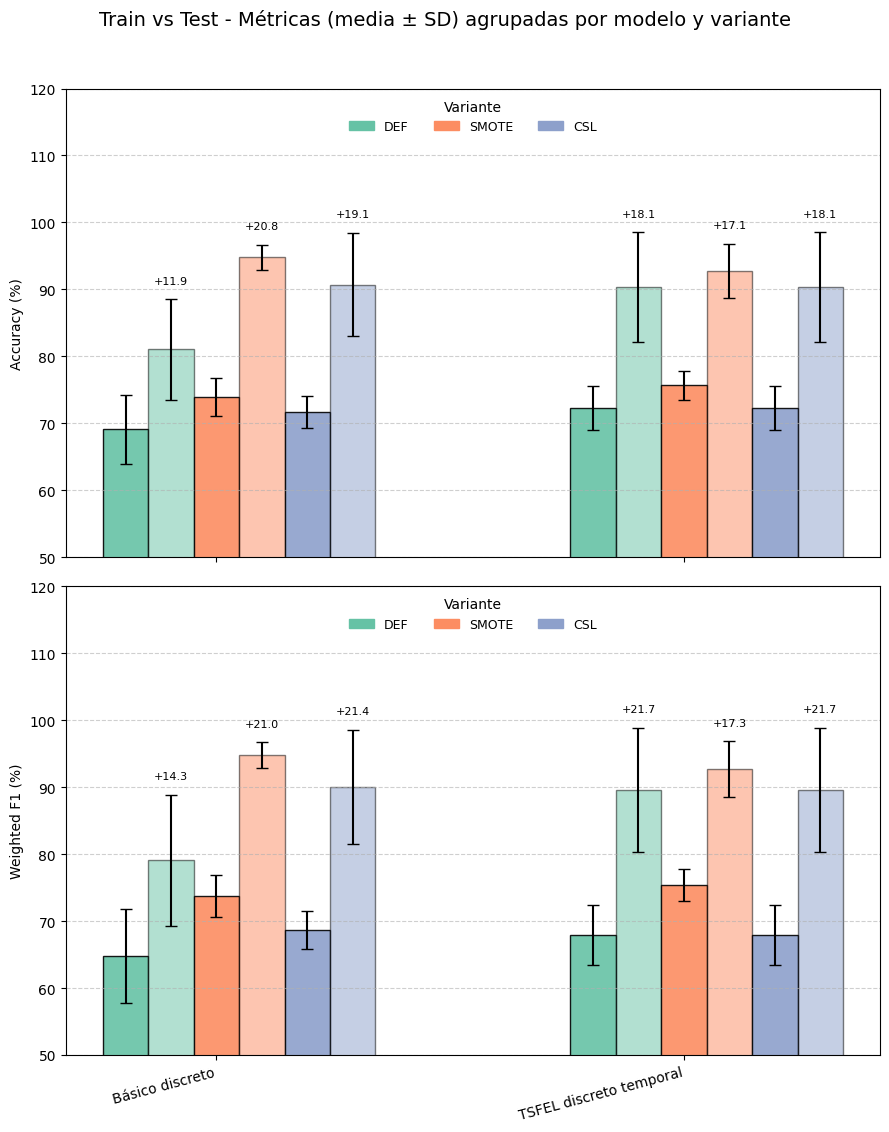

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# -------------------------------------------------------------------------
#  GLOBAL OVER‑FIT SCREEN  (usa global_overfit_metrics ya disponible)
# -------------------------------------------------------------------------
OVERFIT_GAP     = 0.03   # 3 puntos porcentuales
TOP_K_TO_REPORT = 100

# -----------------------------------------------
# 1.  Normalizador de nombre de entrada y variante
# -----------------------------------------------
def parse_key(name):
    """
    Convierte la key del dict en (Entrada normalizada, Variante normalizada).

    Ej.:  "basic|default|CatBoost"      -> ("Básico discreto", "DEF")
          "TSFEL-temporal|smote|CB"    -> ("TSFEL discreto temporal", "SMOTE")
    """
    parts = [p.strip().lower() for p in name.split("|")]
    if len(parts) < 2:
        return None, None

    entrada_raw, variante_raw = parts[0], parts[1]

    # ----- entrada -----
    if "basic" in entrada_raw:
        entrada = "Básico discreto"
    elif "tsfel" in entrada_raw and "temporal" in entrada_raw:
        entrada = "TSFEL discreto temporal"
    else:
        entrada = None

    # ----- variante -----
    var_map = {"default": "DEF", "def": "DEF",
               "smote":   "SMOTE",
               "csl":     "CSL"}
    variante = var_map.get(variante_raw, None)

    return entrada, variante

ranked = sorted(global_overfit_metrics.items(),
                key=lambda kv: kv[1]["f1_mean"],
                reverse=True)[:TOP_K_TO_REPORT]

print("\n======= OVER-FITTING CHECK =======")
for key, m in ranked:
    acc_gap = m["accuracy_train_mean"] - m["accuracy_mean"]
    f1_gap  = m["f1_train_mean"]       - m["f1_mean"]
    status  = "⚠️  OVERFITTING" if (acc_gap > OVERFIT_GAP or f1_gap > OVERFIT_GAP) else "✓  looks OK"
    print(f"{status:17} | {key:<55} | ΔAcc={acc_gap:+.3f}  ΔF1={f1_gap:+.3f}")

# -------------------------------------------------------------------------
#  AGRUPAR Y GRAFICAR  (Básico discreto  /  TSFEL discreto temporal)
# -------------------------------------------------------------------------
entrada_order = ["Básico discreto", "TSFEL discreto temporal"]
variants      = ["DEF", "SMOTE", "CSL"]
metric_sets   = [("Accuracy (%)",     "accuracy_mean","accuracy_train_mean"),
                 ("Weighted F1 (%)",  "f1_mean",      "f1_train_mean")]

# utilidades para construir matrices (filas=Entrada, cols=Variante)
def build_matrix(metric_key):
    mat = np.full((len(entrada_order), len(variants)), np.nan)
    for name, vals in global_overfit_metrics.items():
        entrada, variante = parse_key(name)
        if entrada in entrada_order and variante in variants:
            i = entrada_order.index(entrada)
            j = variants.index(variante)
            mat[i, j] = vals[metric_key] * 100
    return mat

def build_mean_std(metric_mean, metric_std):
    mean_mat = np.full((len(entrada_order), len(variants)), np.nan)
    std_mat  = np.full_like(mean_mat, np.nan)
    for name, vals in global_overfit_metrics.items():
        entrada, variante = parse_key(name)     # misma función de normalizado
        if entrada in entrada_order and variante in variants:
            i = entrada_order.index(entrada)
            j = variants.index(variante)
            mean_mat[i, j] = vals[metric_mean] * 100
            std_mat[i, j]  = vals[metric_std]  * 100
    return mean_mat, std_mat

metric_sets = [("Accuracy (%)","accuracy_mean","accuracy_std","accuracy_train_mean","accuracy_train_std"),
                ("Weighted F1 (%)", "f1_mean","f1_std","f1_train_mean","f1_train_std")]

fig, axes = plt.subplots(len(metric_sets), 1,
                         figsize=(9, 6*len(metric_sets)), sharex=True)

group_gap = 1.2
bar_w     = 0.28
colors    = dict(zip(variants, cm.Set2.colors[:3]))

for ax, (ylabel,
         test_mean_key,  test_std_key,
         train_mean_key, train_std_key) in zip(axes, metric_sets):

    test_mean,  test_std  = build_mean_std(test_mean_key,  test_std_key)
    train_mean, train_std = build_mean_std(train_mean_key, train_std_key)

    base = 0
    cluster_centers = []
    for i, ent in enumerate(entrada_order):
        for j, var in enumerate(variants):
            x_test  = base + j*2*bar_w
            x_train = x_test + bar_w

            # --- Test ---
            ax.bar(x_test, test_mean[i, j],
                   yerr=test_std[i, j], capsize=4,
                   width=bar_w, color=colors[var],
                   edgecolor='black', alpha=0.9)

            # --- Train ---
            ax.bar(x_train, train_mean[i, j],
                   yerr=train_std[i, j], capsize=4,
                   width=bar_w, color=colors[var],
                   edgecolor='black', alpha=0.5)

            # --- Brecha (sube 2 pp por encima del error bar) ---
            y_text = train_mean[i, j] + train_std[i, j] + 2.0
            gap    = train_mean[i, j] - test_mean[i, j]
            ax.text(x_train, y_text, f"{gap:+.1f}",
                    ha='center', va='bottom', fontsize=8)

        cluster_centers.append(base + (len(variants)-1)*bar_w)
        base += len(variants)*2*bar_w + group_gap

    ax.set_ylabel(ylabel)
    ax.set_ylim(50, 120)                      # un poco más de head-room
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas de clúster
for ax in axes:
    ax.set_xticks(cluster_centers)
    ax.set_xticklabels(entrada_order, rotation=15, ha='right')

# -------- leyenda: la misma en ambos paneles ---------
handles = [plt.Rectangle((0,0),1,1,color=colors[v], edgecolor='black',
                         label=v) for v in variants]
for ax in axes:
    ax.legend(handles=handles, title="Variante",
              ncol=3, fontsize=9, frameon=False, loc="upper center")

fig.suptitle("Train vs Test - Métricas (media ± SD) agrupadas por modelo y variante",
             fontsize=14, y=0.94)
plt.tight_layout(rect=[0,0,1,0.92])
plt.show()

# Feature Importance

Llevamos a cabo el analisis de Feature Importance para un unico modelo (el mejor de todos). Similarmente a lo hecho antes, procedemos con agregar un booleano que permita indicar tambien juntar las metricas relevantes para poder llevar a cabo el analisis de FI.

Running models for TSFEL-temporal pipeline...
(469, 1878) (469,)
[0 2 0 1 1 1 2 1 1 1]
3
Performing multi-class classification (PD vs DD vs HC) [Default Mode]...
Setting CatBoost parameters for CatBoost (Fold 1)...
Setting CatBoost parameters...
Not tuning hyperparameters for CatBoost.
Setting CatBoost parameters for CatBoost (Fold 2)...
Setting CatBoost parameters...
Not tuning hyperparameters for CatBoost.
Setting CatBoost parameters for CatBoost (Fold 3)...
Setting CatBoost parameters...
Not tuning hyperparameters for CatBoost.
Setting CatBoost parameters for CatBoost (Fold 4)...
Setting CatBoost parameters...
Not tuning hyperparameters for CatBoost.
Setting CatBoost parameters for CatBoost (Fold 5)...
Setting CatBoost parameters...
Not tuning hyperparameters for CatBoost.

Robustness for model: CatBoost
[accuracy] Metric Mean: 0.7228
[accuracy] Metric Standard Deviation: 0.0330
[accuracy] Coefficient of Variation (CV): 4.56%
[accuracy] Model is robust (CV < 10%)
[f1_score] Metric M

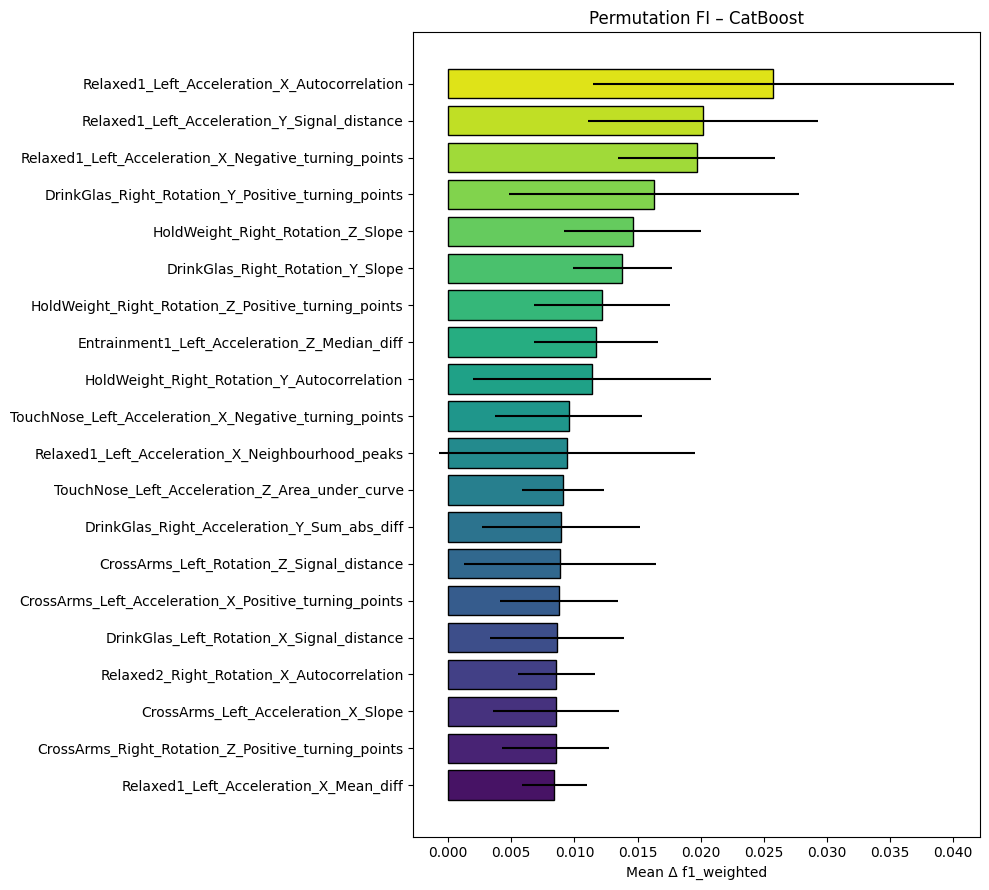


Tree-based FI (avg over folds):
| feature                                                |     mean |       std |
|:-------------------------------------------------------|---------:|----------:|
| Relaxed1_Left_Acceleration_X_Autocorrelation           | 5.31274  | 1.72871   |
| Relaxed1_Left_Acceleration_X_Negative_turning_points   | 3.36416  | 0.903023  |
| Relaxed1_Left_Acceleration_Y_Signal_distance           | 2.94572  | 1.04709   |
| Relaxed1_Left_Acceleration_X_Neighbourhood_peaks       | 1.6812   | 0.636634  |
| DrinkGlas_Right_Rotation_Y_Positive_turning_points     | 1.59835  | 0.500309  |
| DrinkGlas_Right_Rotation_Y_Slope                       | 1.27421  | 0.465796  |
| CrossArms_Left_Rotation_Z_Signal_distance              | 1.18942  | 0.641248  |
| HoldWeight_Right_Rotation_Z_Slope                      | 1.18016  | 0.605184  |
| HoldWeight_Right_Rotation_Z_Positive_turning_points    | 0.858693 | 0.350449  |
| HoldWeight_Right_Rotation_Y_Autocorrelation            | 0.8039

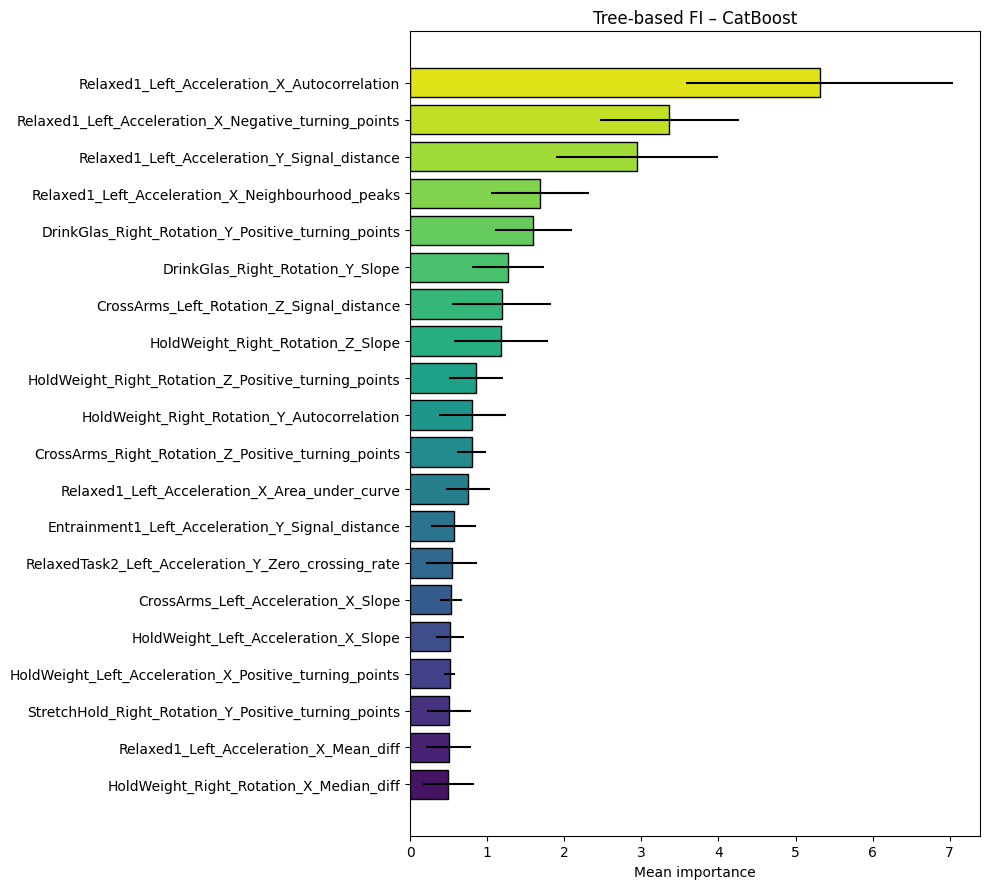


=== CatBoost – Feature Importance ===
  Fold 0: X_test is a DataFrame. Converting to NumPy array for PFI.
  Fold 1: X_test is a DataFrame. Converting to NumPy array for PFI.
  Fold 2: X_test is a DataFrame. Converting to NumPy array for PFI.
  Fold 3: X_test is a DataFrame. Converting to NumPy array for PFI.
  Fold 4: X_test is a DataFrame. Converting to NumPy array for PFI.

Permutation FI (avg over folds):
| feature                                               |       mean |        std |
|:------------------------------------------------------|-----------:|-----------:|
| Relaxed1_Left_Acceleration_X_Autocorrelation          | 0.0232693  | 0.0108472  |
| Relaxed1_Left_Acceleration_Y_Signal_distance          | 0.0168611  | 0.00752858 |
| Relaxed1_Left_Acceleration_X_Negative_turning_points  | 0.0155731  | 0.00481778 |
| DrinkGlas_Right_Rotation_Y_Positive_turning_points    | 0.0131915  | 0.00865829 |
| HoldWeight_Right_Rotation_Z_Slope                     | 0.0121482  | 0.00370796 |

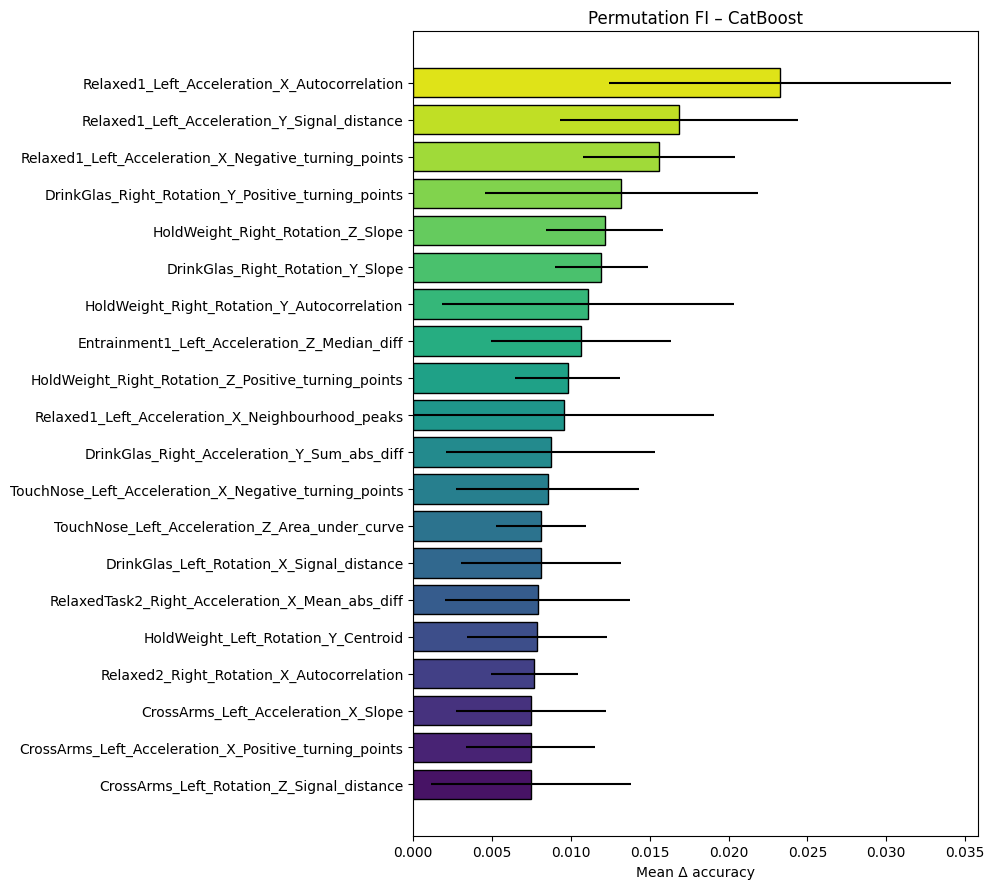


Tree-based FI (avg over folds):
| feature                                                |     mean |       std |
|:-------------------------------------------------------|---------:|----------:|
| Relaxed1_Left_Acceleration_X_Autocorrelation           | 5.31274  | 1.72871   |
| Relaxed1_Left_Acceleration_X_Negative_turning_points   | 3.36416  | 0.903023  |
| Relaxed1_Left_Acceleration_Y_Signal_distance           | 2.94572  | 1.04709   |
| Relaxed1_Left_Acceleration_X_Neighbourhood_peaks       | 1.6812   | 0.636634  |
| DrinkGlas_Right_Rotation_Y_Positive_turning_points     | 1.59835  | 0.500309  |
| DrinkGlas_Right_Rotation_Y_Slope                       | 1.27421  | 0.465796  |
| CrossArms_Left_Rotation_Z_Signal_distance              | 1.18942  | 0.641248  |
| HoldWeight_Right_Rotation_Z_Slope                      | 1.18016  | 0.605184  |
| HoldWeight_Right_Rotation_Z_Positive_turning_points    | 0.858693 | 0.350449  |
| HoldWeight_Right_Rotation_Y_Autocorrelation            | 0.8039

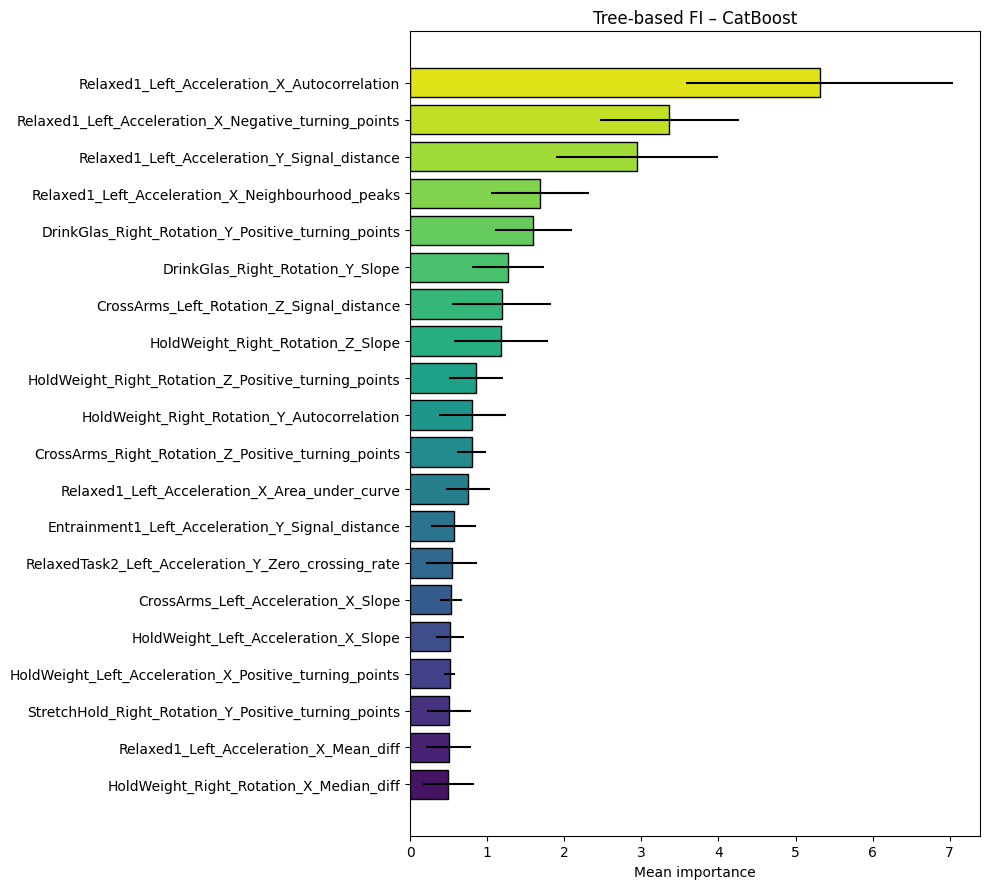

In [16]:
import seaborn as sns
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

feature_importance_pipeline_labels = ['TSFEL-temporal']
feature_importance_variants    = ["default", "smote", "csl"]

# Use best overall models
feature_importance_variants_to_models = {
    'TSFEL-temporal': {
        'default': { 
            "CatBoost": [
                CatBoostClassifier(
                    random_state=42,
                    iterations=10000,
                    eval_metric='Accuracy',
                    loss_function='MultiClass',
                    learning_rate=0.005,
                    depth=3,
                    l2_leaf_reg=5,
                    od_type = "Iter",
                    od_wait=1000
                ), {}
            ]
        }, #{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
    }
}

global_importance_permutation = {} 
global_importance_tree       = {}

def _generate_descriptive_feature_names():
    """
    Generates a list of descriptive feature names for the 1848 TSFEL features
    and 30 questionnaire features.
    """
    tasks = ["Relaxed1", "Relaxed2", "RelaxedTask1", "RelaxedTask2",
             "StretchHold", "HoldWeight", "DrinkGlas", "CrossArms",
             "TouchNose", "Entrainment1", "Entrainment2"]
    wrists = ["Left", "Right"]
    # Use sensor names as they appear in the reference's channel name examples
    sensor_display_map = {"Accelerometer": "Acceleration", "Gyroscope": "Rotation"}
    # These are the actual sensor types iterated over during data generation
    sensor_keys_for_iteration = ["Accelerometer", "Gyroscope"]
    axes = ["X", "Y", "Z"]
    # TSFEL features in the order they are extracted
    tsfel_features = [
        "Area_under_curve", "Autocorrelation", "Centroid", "Mean_abs_diff",
        "Mean_diff", "Median_abs_diff", "Median_diff", "Negative_turning_points",
        "Neighbourhood_peaks", "Positive_turning_points", "Signal_distance",
        "Slope", "Sum_abs_diff", "Zero_crossing_rate"
    ]

    descriptive_names = []

    # Generate names for the 1848 sensor-based features
    for task in tasks:
        for wrist in wrists:
            for sensor_key in sensor_keys_for_iteration:
                sensor_name_part = sensor_display_map[sensor_key] # Get the display name
                for axis in axes:
                    for tsfel_feature in tsfel_features:
                        descriptive_names.append(f"{task}_{wrist}_{sensor_name_part}_{axis}_{tsfel_feature}")
    
    # Expected number of sensor features: 11*2*2*3*14 = 1848
    if len(descriptive_names) != 1848:
        print(f"Warning: Generated {len(descriptive_names)} sensor feature names, expected 1848.")

    # Generate names for the 30 questionnaire features
    num_questionnaire_features = 30
    for i in range(1, num_questionnaire_features + 1):
        descriptive_names.append(f"Questionnaire_{i}")
    
    # Expected total number of features: 1848 + 30 = 1878
    if len(descriptive_names) != 1878:
        print(f"Warning: Generated total {len(descriptive_names)} feature names, expected 1878.")
        
    return descriptive_names

def analyze_feature_importance(results, X_original, # X_original is your X_vals[pipe_label] (NumPy array)
                               scoring="accuracy", n_repeats_pfi=10,
                               top_k=20):
    """
    Analyzes and displays feature importance.
    Assumes models in 'results' were trained on NumPy arrays (or equivalent index-based data).
    Converts X_test to NumPy if it's a DataFrame from folds.
    Uses descriptive names for labeling results based on feature index.
    """
    
    descriptive_feat_names = _generate_descriptive_feature_names()

    if X_original.shape[1] != len(descriptive_feat_names):
        raise ValueError(
            f"Feature count mismatch: X_original has {X_original.shape[1]} columns, "
            f"but {len(descriptive_feat_names)} descriptive names were generated. "
            "Ensure _generate_descriptive_feature_names aligns with your data's column structure."
        )
    
    num_total_features = len(descriptive_feat_names)
    
    global global_importance_permutation, global_importance_tree   # make them writable here
    score_tag = ("accuracy" if scoring.startswith("accuracy")
                 else ("f1" if "f1" in scoring else scoring))

    for model_name, folds in results.items():
        print(f"\n=== {model_name} – Feature Importance ===")
        perm_collect  = []
        tree_collect  = []
        
        for k, fold in enumerate(folds):
            mdl  = fold["fitted_model"]
            X_te_from_fold = fold["X_test"] # This is what's reported as a DataFrame
            y_te = fold["y_test"]

            X_te_np = None # Will hold the NumPy version of X_test data

            if isinstance(X_te_from_fold, pd.DataFrame):
                print(f"  Fold {k}: X_test is a DataFrame. Converting to NumPy array for PFI.")
                X_te_np = X_te_from_fold.to_numpy()
            elif isinstance(X_te_from_fold, np.ndarray):
                print(f"  Fold {k}: X_test is already a NumPy array.")
                X_te_np = X_te_from_fold
            else:
                print(f"  Fold {k}: X_test is an unexpected type ({type(X_te_from_fold)}). Skipping PFI for this fold.")
                # Attempt to get tree importance if possible
                if hasattr(mdl, "feature_importances_"):
                    importances = mdl.feature_importances_
                    if len(importances) == num_total_features:
                        tree_collect.append(importances)
                continue # Skip to next fold for PFI processing

            # Validate the shape of the resulting NumPy array
            if X_te_np.shape[1] != num_total_features:
                print(f"  Fold {k}: Processed X_test (X_te_np) has {X_te_np.shape[1]} columns, "
                      f"expected {num_total_features}. Skipping PFI for this fold.")
                if hasattr(mdl, "feature_importances_"): # Attempt tree-based
                    importances = mdl.feature_importances_
                    if len(importances) == num_total_features:
                        tree_collect.append(importances)
                continue # Skip to next fold for PFI processing

            # ----- Permutation Importance (using NumPy array X_te_np) -----
            try:
                r = permutation_importance(mdl, X_te_np, y_te,
                                           n_repeats=n_repeats_pfi,
                                           random_state=42,
                                           n_jobs=-1,
                                           scoring=scoring)
                if len(r.importances_mean) == num_total_features:
                    perm_collect.append(r.importances_mean)
                else:
                    print(f"  Fold {k}: PFI result length mismatch. Expected {num_total_features}, got {len(r.importances_mean)}.")
            except Exception as e:
                print(f"  Fold {k}: PFI no disponible ({e})")

            # ----- Tree-based Importance -----
            if hasattr(mdl, "feature_importances_"):
                importances = mdl.feature_importances_
                if len(importances) == num_total_features:
                    tree_collect.append(importances)
                else:
                    print(f"  Fold {k}: Tree-based feature_importances_ length ({len(importances)}) "
                          f"does not match expected feature count ({num_total_features}). Skipping.")
        
        # ---------- Aggregation and Plotting (using descriptive_feat_names) ----------
        if perm_collect:
            valid_perm_folds = [p for p in perm_collect if len(p) == num_total_features]
            if valid_perm_folds:
                perm_mean = np.mean(valid_perm_folds, axis=0)
                perm_std  = np.std(valid_perm_folds,  axis=0)
                
                p_df = (pd.DataFrame({"feature": descriptive_feat_names,
                                      "mean": perm_mean, "std":  perm_std})
                        .sort_values("mean", ascending=False))
                
                global_importance_permutation.setdefault(model_name, {})
                global_importance_permutation[model_name][score_tag] = [
                    {
                        "feature": feat,
                        f"{score_tag}_avg":  avg,
                        f"{score_tag}_std":  std,
                    }
                    for feat, avg, std in zip(
                        p_df["feature"].tolist(),
                        p_df["mean"].tolist(),
                        p_df["std"].tolist(),
                    )
                ]

                print("\nPermutation FI (avg over folds):")
                print(tabulate(p_df.head(top_k), headers="keys", tablefmt="pipe", showindex=False))
                
                top_p = p_df.head(top_k).iloc[::-1]
                plt.figure(figsize=(10, max(6, top_k * 0.45)))
                plt.barh(top_p["feature"], top_p["mean"], xerr=top_p["std"],
                         color=sns.color_palette("viridis", n_colors=len(top_p)), edgecolor="black")
                plt.xlabel(f"Mean Δ {scoring}")
                plt.title(f"Permutation FI – {model_name}")
                plt.tight_layout()
                plt.show()
            else:
                print(f"  No valid PFI results collected for {model_name} to aggregate.")

        if tree_collect:
            valid_tree_folds = [t for t in tree_collect if len(t) == num_total_features]
            if valid_tree_folds:
                tree_mean = np.mean(valid_tree_folds, axis=0)
                tree_std  = np.std(valid_tree_folds,  axis=0)

                t_df = (pd.DataFrame({"feature": descriptive_feat_names,
                                      "mean": tree_mean, "std":  tree_std})
                        .sort_values("mean", ascending=False))
                
                # ---- persist ALL tree importances (desc order) ----
                global_importance_tree.setdefault(model_name, {})
                global_importance_tree[model_name][score_tag] = [
                    {
                        "feature": feat,
                        f"{score_tag}_avg":  avg,
                        f"{score_tag}_std":  std,
                    }
                    for feat, avg, std in zip(
                        t_df["feature"].tolist(),
                        t_df["mean"].tolist(),
                        t_df["std"].tolist(),
                    )
                ]
                
                print("\nTree-based FI (avg over folds):")
                print(tabulate(t_df.head(top_k), headers="keys", tablefmt="pipe", showindex=False))

                top_t = t_df.head(top_k).iloc[::-1]
                plt.figure(figsize=(10, max(6, top_k * 0.45)))
                plt.barh(top_t["feature"], top_t["mean"], xerr=top_t["std"],
                         color=sns.color_palette("viridis", n_colors=len(top_t)), edgecolor="black")
                plt.xlabel("Mean importance")
                plt.title(f"Tree-based FI – {model_name}")
                plt.tight_layout()
                plt.show()
            else:
                print(f"  No valid Tree FI results collected for {model_name} to aggregate.")

        if not perm_collect and not tree_collect: # Or more accurately, if not valid_perm_folds and not valid_tree_folds
            print(f"  No usable feature importances were obtained for {model_name}.")
            
for pipe_label in feature_importance_pipeline_labels:
    X = X_vals[pipe_label]
    y = y_vals[pipe_label]

    print(f"Running models for {pipe_label} pipeline...")
    print(X.shape, y.shape)
    print(y[:10])

    # -----------------------------------------------------------------------------
    # Multi-Class Classification (no changes): PD vs DD vs HC
    # -----------------------------------------------------------------------------
    print(len(np.unique(y)))
    if len(np.unique(y)) == 3:
        print("Performing multi-class classification (PD vs DD vs HC) [Default Mode]...")
        results_default = run_cv(X, y, feature_importance_variants_to_models[pipe_label]['default'], n_splits=5, mode="default", tune_inner=False, param_grids=param_grids, train_metrics=True, feature_importance=True)
        overall_default = evaluate_cv(results_default, target_names=['HC', 'PD', 'DD'], show_train=True)
        analyze_feature_importance(results_default, X_original=X, scoring='f1_weighted', n_repeats_pfi=10)
        analyze_feature_importance(results_default, X_original=X, scoring='accuracy', n_repeats_pfi=10)
    else:
        print("Multi-class classification (PD vs DD vs HC) is not possible with the current labels.")